# Preliminary tests for OTGAN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import argparse
from datetime import datetime

import torch
import torchvision
from torchvision import datasets, transforms
import torch
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
import tqdm

In [2]:
# path = "C:/Users/Philo/Documents/3A -- ENSAE/Optimal transport/OTGAN"
# os.chdir(path)

#### Model parameters and hyperparameters

In [3]:
args={}
kwargs={}
args['batch_size']=10
args['val_batch_size']=10
args['epochs']=10   
# args['lr']=0.01 
# args['momentum']=0.5
args['seed']=1 #random seed
args['cuda']=True if torch.cuda.is_available() else False
device = "cuda" if args['cuda']==True else "cpu"

In [4]:
np.random.seed(args['seed'])
torch.random.manual_seed(args['seed']) #noGPU
# torch.cuda.seed(args['seed']) #single GPU
# torch.cuda.manual_seed_all(args['seed']) #several GPUs


#### Load MNIST dataset

In [5]:
# Define dataset transformation
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,)) #use MNIST mean and std
                              ])

# ## Preliminary step : download dataset
trainset = datasets.MNIST('../data/MNIST', download=True, train=True, transform=transform)
# valset = datasets.MNIST('../data/MNIST', download=True, train=False, transform=transform)

trainset = torchvision.datasets.MNIST('../data/MNIST', train=True, transform=transform)
# valset = torchvision.datasets.MNIST('../data/MNIST', train=False, transform=transform)


Size of the input image :  torch.Size([1, 28, 28])


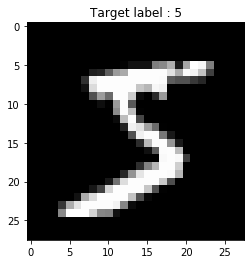

In [6]:
index = 0
print("Size of the input image : ",trainset[index][0].size())
plt.imshow(trainset[index][0].view(trainset[index][0].size()[1],trainset[index][0].size()[2]),cmap='gray')
plt.title("Target label : "+str(trainset[index][1]))
plt.show()

#### Add padding to obtain 32x32 images

In [7]:
from torchvision.datasets import VisionDataset
from albumentations import Resize, Compose
from torchvision import transforms

In [9]:
# check_black = [tup[0][0,0,0].item() for tup in trainset]+[tup[0][0,0,0].item() for tup in valset]
# assert len(check_black) == len(trainset) + len(valset)
# set(check_black)
# padding_val = list(set(check_black))[0]
padding_val = trainset[0][0][0][0][0]
resizing_val = 32

In [10]:
class MNISTPad(VisionDataset):
    def __init__(self, dataset, transform, transform_val):
        self.images = [tup[0] for tup in dataset]
        self.target = [tup[1] for tup in dataset]
        self.transform = transform
        self.transform_val = transform_val
        
        # Check length of target and image match
        assert len(self.images) == len(self.target)
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        target = self.target[index]
        img = self.images[index]
        if self.transform == "padding":
            img = F.pad(input=img, 
                        # utiliser l'étoile ? 
                        pad=(self.transform_val, self.transform_val, self.transform_val, self.transform_val),
                        mode='constant', value=padding_val)
        
#         if self.transform == "resizing":
            ##TODO
        return img, target

In [12]:
trainset_pad = MNISTPad(trainset, "padding", 2)
# valset_pad = MNISTPad(valset, "padding", 2)

In [15]:
# trainset_pad

In [196]:
# # Test for the resizing :
# resizing_transform = Compose([
#                         transforms.ToPILImage(),
#                         Resize(height = resizing_val, width = resizing_val, always_apply = True),
#                         transforms.ToTensor(),
#                         ])
# resizing_transform(source)

#### Train loader

In [252]:
train_loader = DataLoader(trainset, args['batch_size'], shuffle=True, **kwargs)
val_loader = DataLoader(valset, args['val_batch_size'], shuffle=True, **kwargs)

In [253]:
train_pad_loader = DataLoader(trainset_pad, args['batch_size'], shuffle=True, **kwargs)
val_pad_loader = DataLoader(valset, args['val_batch_size'], shuffle=True, **kwargs)

#### Generate noise 
As showed in the article for the CIFAR dataset : use a $Uniform([-1,1])$

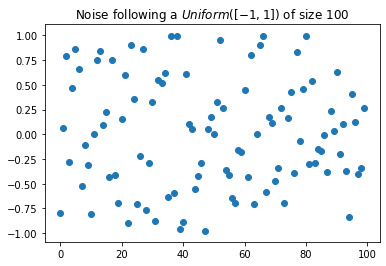

In [218]:
k=100
z = (torch.rand(k)*2)-1
plt.scatter(range(k),z)
plt.title("Noise following a $Uniform([-1,1])$ of size "+str(k))
plt.show()

In [364]:
###TODO

class _UpBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels = 2*in_channels, out_channels = 2*in_channels, 
                              kernel_size = 5, padding=2, stride = 1)

    def forward(self, x: Tensor) -> Tensor:
        x =  F.interpolate(x, scale_factor=(2,2), mode = "nearest") 
        print("x after interpolate",x.size())
        x = self.conv(x)
        print('x after conv',x.size())
        x = F.glu(x,dim=1)
        print("x after glu",x.size())
        return x

In [359]:
# class Generator32x32(nn.Module):
#     def __init__(self, input_dim: int=100):
#         super(Generator32x32, self).__init__()
# #         self.linear = nn.Linear(in_features=input_dim, out_features=16384)
#         self.linear = nn.Linear(in_features=input_dim, out_features=32768)
#         self.conv = nn.Conv2d(in_channels = 1024, out_channels = 1024, kernel_size = 5, padding=2, stride = 1)
#         self.conv2 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 5, padding=2, stride = 1)
#         self.conv3 = nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 5, padding=2, stride = 1)
#         ###Pas bizarre de mettre un padding de 2?? 
#         self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 3, kernel_size = 5, padding=2, stride = 1)
        
#     def forward(self, x: Tensor):
#         print("xshape",x.size())
#         x1 = self.linear(x) # size 32768 (??) OR 16384 (??)
#         print("x1shape",x1.size())
#         x1_a = F.glu(x1) # size 16384 
#         print("x1_ashape",x1_a.size())
#         x2 = x1_a.reshape(1,1024,4,4) # reshape to [1, 1024, 4, 4] (add batch size)
#         print("x2shape",x2.size())
    
#         x3 =  F.interpolate(x2, scale_factor=(2,2), mode = "nearest") ##Question : ok to do it this way ? or do it twice ?
#         print("x3",x3.size())
#         x4 = self.conv(x3)
#         print(x4.size())
#         x5 = F.glu(x4,dim=1)
#         print(x5.size())
        
#         x6 =  F.interpolate(x5, scale_factor=(2,2), mode = "nearest") ##Question : ok to do it this way ? or do it twice ?
#         print("x6",x6.size())
#         x7 = self.conv2(x6)
#         print(x7.size())
#         x8 = F.glu(x7,dim=1)
#         print(x8.size())
        
#         x9 =  F.interpolate(x8, scale_factor=(2,2), mode = "nearest") ##Question : ok to do it this way ? or do it twice ?
#         print("x9",x9.size())
#         x10 = self.conv3(x9)
#         print(x10.size())
#         x11 = F.glu(x10,dim=1)
#         print(x11.size())
        
#         # last part
#         x12 = self.conv4(x11)
#         print("x12",x12.size())
#         x13 = torch.tanh(x12)
#         print(x13.size())
#         out = x13
#         return out

In [369]:
class Generator32x32(nn.Module):
    def __init__(self, input_dim: int=100):
        super(Generator32x32, self).__init__()
#         self.linear = nn.Linear(in_features=input_dim, out_features=16384)
        self.linear = nn.Linear(in_features=input_dim, out_features=32768)
        self.up1 = _UpBlock(512) ###Pas bizarre de mettre un padding de 2?? 
        self.up2 = _UpBlock(256)
        self.up3 = _UpBlock(128)
        self.last_conv = nn.Conv2d(in_channels = 128, out_channels = 3, kernel_size = 5, padding=2, stride = 1)
        
    def forward(self, x: Tensor):
        print("xshape",x.size())
        x1 = self.linear(x) # size 32768 (??) OR 16384 (??)
        print("x1shape",x1.size())
        x1_a = F.glu(x1) # size 16384 
        print("x1_ashape",x1_a.size())
        x2 = x1_a.reshape(1,1024,4,4) # reshape to [1, 1024, 4, 4] (add batch size)
        print("x2shape",x2.size())
    
        x3 =  self.up1(x2)
        print(x3.size())
        
        x4 =  self.up2(x3)
        print(x4.size())
        
        x5 =  self.up3(x4)
        print(x5.size())
        
        # last part
        x12 = self.last_conv(x5)
        print("x12",x12.size())
        x13 = torch.tanh(x12)
        print(x13.size())
        out = x13
        return out ###Question : need to reshape at the end ?? 

In [240]:
# # iterator = tqdm.tqdm(enumerate(train_loader), desc='Training epoch {:d}'.format(args['epochs']))
# iterator = enumerate(train_loader)
# for batch_idx, (img, target) in iterator:
#     img = img.to(device)
#     target = target.to(device)

In [370]:
model = Generator32x32()
model(z)

xshape torch.Size([100])
x1shape torch.Size([32768])
x1_ashape torch.Size([16384])
x2shape torch.Size([1, 1024, 4, 4])
x after interpolate torch.Size([1, 1024, 8, 8])
x after conv torch.Size([1, 1024, 8, 8])
x after glu torch.Size([1, 512, 8, 8])
torch.Size([1, 512, 8, 8])
x after interpolate torch.Size([1, 512, 16, 16])
x after conv torch.Size([1, 512, 16, 16])
x after glu torch.Size([1, 256, 16, 16])
torch.Size([1, 256, 16, 16])
x after interpolate torch.Size([1, 256, 32, 32])
x after conv torch.Size([1, 256, 32, 32])
x after glu torch.Size([1, 128, 32, 32])
torch.Size([1, 128, 32, 32])
x12 torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])


tensor([[[[ 0.0105,  0.0104,  0.0095,  ...,  0.0101,  0.0104,  0.0119],
          [ 0.0101,  0.0099,  0.0091,  ...,  0.0098,  0.0106,  0.0122],
          [ 0.0101,  0.0102,  0.0101,  ...,  0.0093,  0.0112,  0.0131],
          ...,
          [ 0.0092,  0.0099,  0.0094,  ...,  0.0091,  0.0104,  0.0121],
          [ 0.0084,  0.0092,  0.0095,  ...,  0.0097,  0.0111,  0.0124],
          [ 0.0092,  0.0092,  0.0094,  ...,  0.0099,  0.0114,  0.0122]],

         [[-0.0058, -0.0057, -0.0050,  ..., -0.0060, -0.0060, -0.0041],
          [-0.0047, -0.0053, -0.0050,  ..., -0.0061, -0.0065, -0.0047],
          [-0.0051, -0.0068, -0.0067,  ..., -0.0066, -0.0076, -0.0059],
          ...,
          [-0.0055, -0.0063, -0.0053,  ..., -0.0053, -0.0068, -0.0049],
          [-0.0031, -0.0041, -0.0033,  ..., -0.0036, -0.0056, -0.0046],
          [-0.0029, -0.0037, -0.0038,  ..., -0.0031, -0.0049, -0.0045]],

         [[ 0.0032,  0.0048,  0.0034,  ...,  0.0051,  0.0046,  0.0062],
          [ 0.0042,  0.0043,  